# Actividad 2: Separación de palabras en una página
### Librerías

In [1]:
%matplotlib inline 

import matplotlib.pyplot as plt
import cv2
import numpy as np

### Funciones
Se crea una función para graficar las imágenes, sin ejes, margen, más grandes, en escla de grises y proporcionadas.

In [2]:

def formated_imshow(image):
    dim = image.shape

    fig = plt.figure(frameon=False)
    fig.set_size_inches(8,8*dim[0]/dim[1])
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow( image, aspect='auto', cmap='gray')

### Cargar la imagen

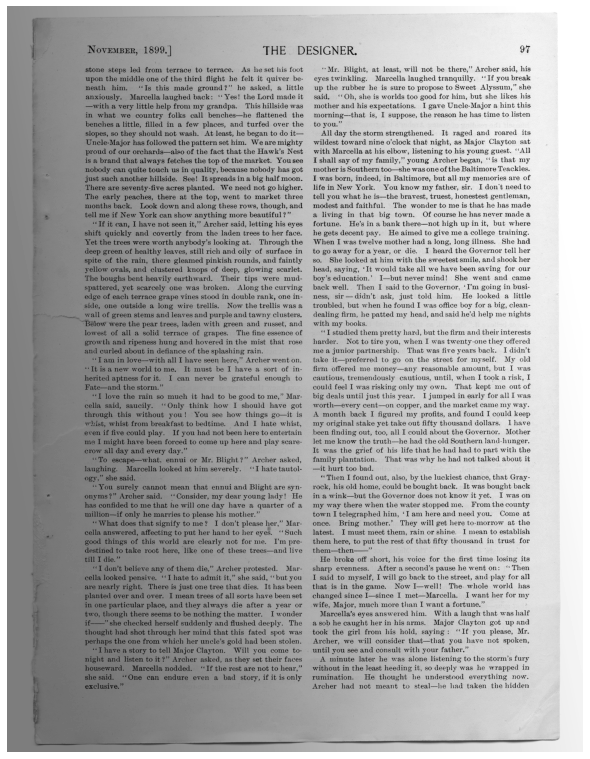

In [3]:
img = cv2.imread('pictures/book1.bmp')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
formated_imshow(img)

In [4]:
img.shape

(3300, 2550)

### Preprocesado de la imagen

Por ahora sólo se contempla que la imagen tenga problemas de iluminación y detalles del borde de página. No sugiero complicarnos más en este asunto.

#### Corrección de problemas de iluminación
Primero hay que desenfocar la imagen, esto se logra promediando con una retícula de tamaño ´MAX_KERNEL_LENGTH´ con sólo unos.

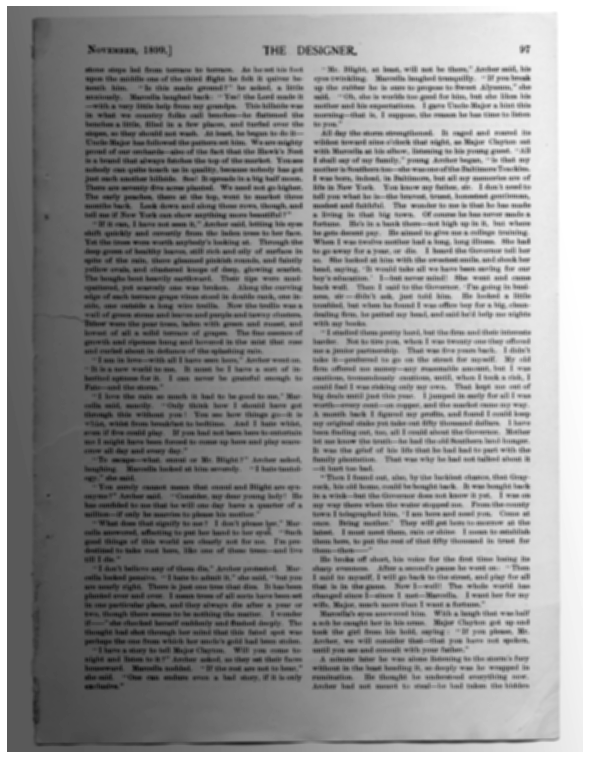

In [5]:
MAX_KERNEL_LENGTH = 15

blurred = cv2.blur(src = img, ksize=(MAX_KERNEL_LENGTH, MAX_KERNEL_LENGTH))
formated_imshow(blurred)

Para que quede más desenfocado se aplica muchas veces el mismo proceso. De esta manera se obtiene una aproximación de como es la luz en la imagen.

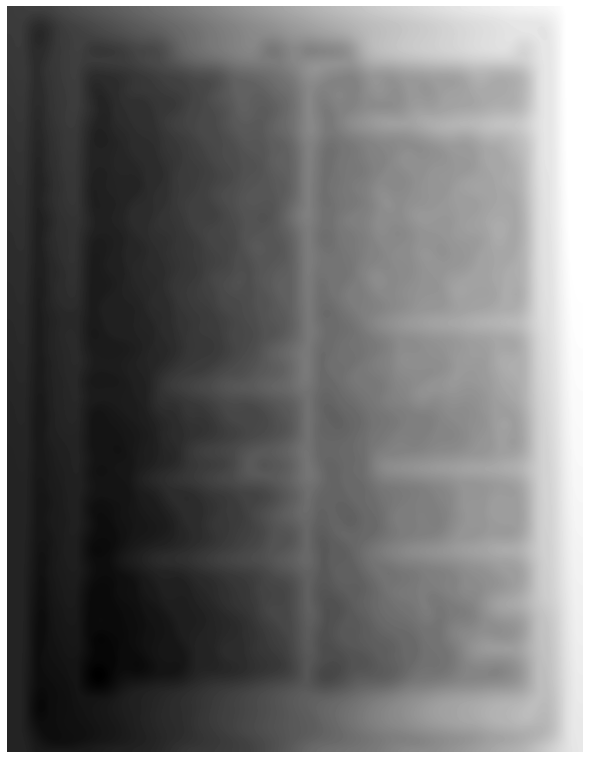

In [6]:
for _ in range(1,100):
    blurred = cv2.blur(src = blurred, 
                       ksize=(MAX_KERNEL_LENGTH, MAX_KERNEL_LENGTH))

formated_imshow(blurred)

Dividimos la imagen original por la desenfocada, normalizamos y corregimos el formato. Observe que ya no tiene problemas de iluminación:

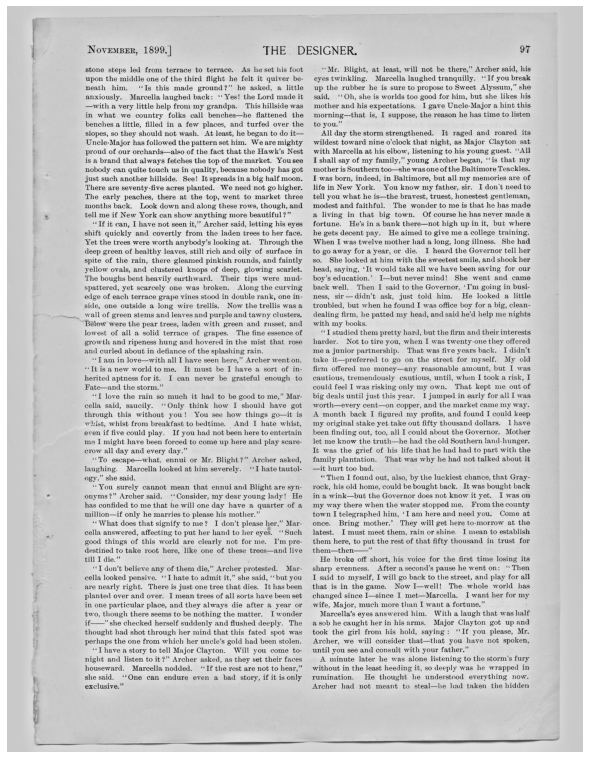

In [7]:
corrected = cv2.normalize(src=img/blurred, 
                          dst=img, 
                          alpha=0, 
                          beta=255, 
                          norm_type=cv2.NORM_MINMAX)

corrected = np.round(corrected)
corrected = corrected.astype(np.uint8)
formated_imshow(corrected)

Ahora ponemos un _zoom_:

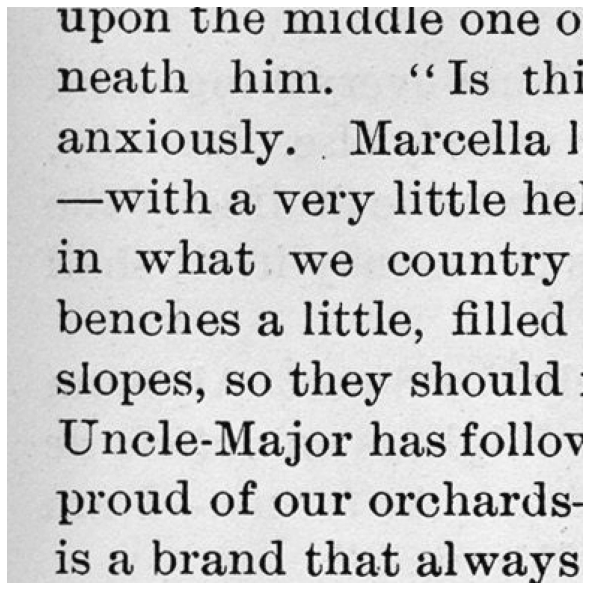

In [8]:
zoom_intervals = (slice(315,700), slice(315,700))
formated_imshow(corrected[zoom_intervals])

### Umbral

Para quedarnos con una imagen enteramente en blanco y negro utilizamos un umbral con un valor de `THRESHOLD_LIMIT` determinado al dedazo. Se usa la opción `cv2.THRESH_BINARY_INV`, que además invierte, porque así es más sencillo identificar figuras para el ojo humano.

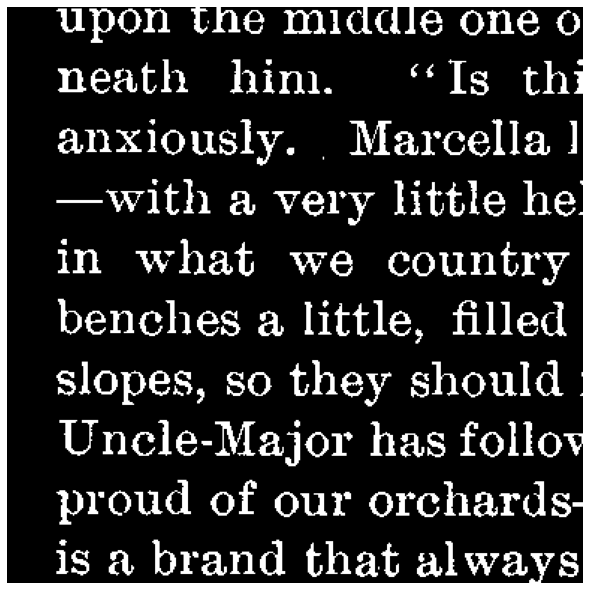

In [9]:
THRESHOLD_LIMIT = 130
_, thresh = cv2.threshold(corrected, THRESHOLD_LIMIT, 255, cv2.THRESH_BINARY_INV)
formated_imshow(thresh[zoom_intervals])

### Filtros morfológicos

Creamos una retícula ´kernel´. Aquí se está utilizando una retícula circular, pero habría que probar con distintos tamaños y formas de la retícula y ver cuál es la mejor.

Luego aplicamos una diltación con ´dilate´ para que se junten las palabras como un sólo elemento:

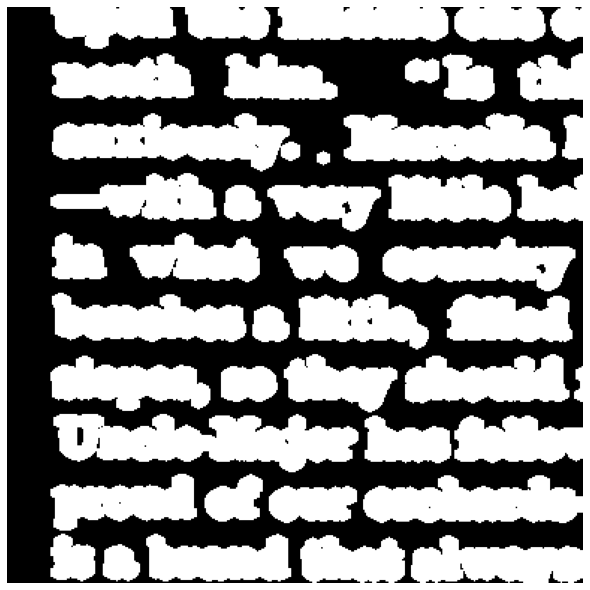

In [10]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
dilation = cv2.dilate(thresh, kernel, iterations=2)
formated_imshow(dilation[zoom_intervals])

En la imagen de arriba se tiene el priblemas de que aparecen manchas pequeñas, detectadas como palabras, como el pequeño punto a lado del punto verdadero de la palabra ´anxiously´. A continuación muestro una combinación de operaciones que mejora la calidad de detección de palabras.

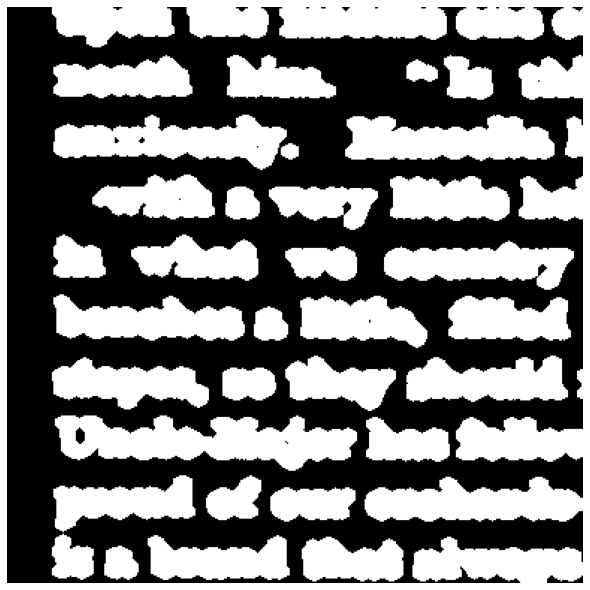

In [60]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
dilation = cv2.dilate(thresh, kernel, iterations=5)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
erosion = cv2.erode(dilation, kernel, iterations=6)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
dilation2 = cv2.dilate(erosion, kernel, iterations=2)


formated_imshow(dilation2[zoom_intervals])

Noten que ahora el pequeño punto ya desapareció y se tienen ventajas adicionales: los signos de puntuación están más separados y desparecieron los guiónes largos.

Aquí hace falta algo de procesado. Por ejemplo, estoy seguro que la pequeña mancha que está al lado del punto de la palabra _anxiously_ se puede eliminar con alguna combinación de erosión y una retícula especial ante de juntar las palabras, pero no lo he logrado.

### Detección de contornos.
La función ``findContours` detecta y acomoda de forma autómatica los contorno de cada objeto blanco dentro de un arreglo de varias dimensiones. Tiene varias opciones, aquí presentó las más básicas, pero se podrían implementar otras:

In [61]:
contours, hierarchy = cv2.findContours(dilation2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


Aquí grafico los contornos que la función detecto, sobreponiéndolos en una imagen blanca.

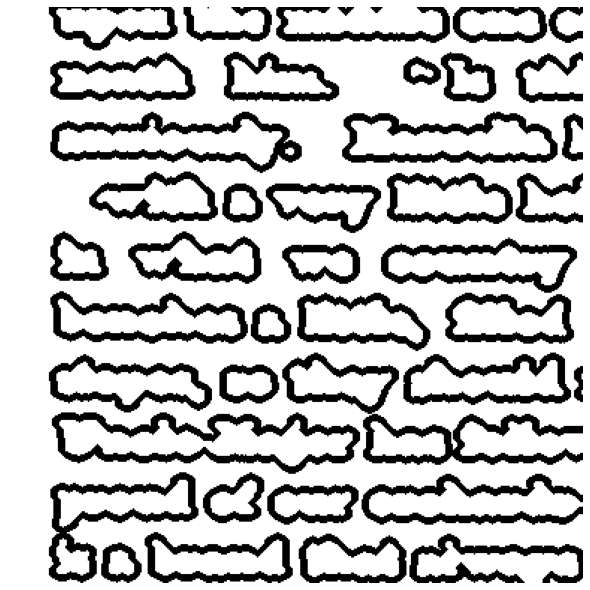

In [62]:
white = np.ones(dilation.shape, np.uint8)
img_countours = cv2.drawContours(white, contours, -1, (0,255,0), 3)
formated_imshow(img_countours[zoom_intervals])

### Filtrado y estadística

#### Máximos y mínimos de las coordenadas de cada figura.

Primero, aquí creo arrreglos para guardar las posiciones máximas y mínimas de cada contorno:

In [63]:
xmins = []
xmaxs = []
ymins = []
ymaxs = []

for cnt in contours:
    xs = [cnt[i][0][0] for i in range(len(cnt))]
    ys = [cnt[i][0][1] for i in range(len(cnt))]
    xmins = np.append(xmins, np.min(xs))
    ymins = np.append(ymins, np.min(ys))
    xmaxs = np.append(xmins, np.max(xs))
    ymaxs = np.append(ymins, np.max(ys))

El objetivo de esto, es poder quitar el borde de la página. Por ejemplo muestro un histograma con los mínimos en x:

(array([12.,  1.,  1., 79., 73., 59., 56., 51., 55., 70., 52., 55., 66.,
        58., 58., 56., 19., 82., 68., 55., 57., 59., 66., 56., 54., 59.,
        64., 53., 56., 52.]),
 array([ 108.        ,  181.16666667,  254.33333333,  327.5       ,
         400.66666667,  473.83333333,  547.        ,  620.16666667,
         693.33333333,  766.5       ,  839.66666667,  912.83333333,
         986.        , 1059.16666667, 1132.33333333, 1205.5       ,
        1278.66666667, 1351.83333333, 1425.        , 1498.16666667,
        1571.33333333, 1644.5       , 1717.66666667, 1790.83333333,
        1864.        , 1937.16666667, 2010.33333333, 2083.5       ,
        2156.66666667, 2229.83333333, 2303.        ]),
 <BarContainer object of 30 artists>)

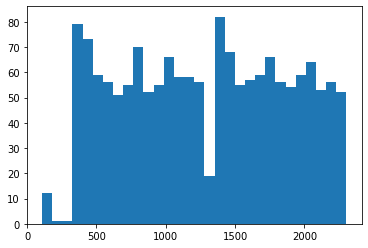

In [64]:
plt.hist(xmins, bins=30)

de izquierda a derecha el los máximos locales del histograma muestran:
* Un pico bajo que corresponde al borde de la hoja.
* Un segundo pico que muestra donde está iniciando la primer columna.
* Un tercer pico donde inicia la segunda columna.

Esta información se podría utilizar para filtrar la imagen de alguna manera, por ejemplo, podemos usar la frecuencia y quitar los figuras con valores poco frecuentes.

#### Áreas

Ahora cuento creo un arreglo con el área de cada figura. Y aplico el histograma:

(array([174., 171., 191., 337., 286., 135., 118.,  77.,  56.,  22.,  10.,
          6.,  10.,   3.,   0.,   0.,   2.,   0.,   1.,   1.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([   44.   ,   376.125,   708.25 ,  1040.375,  1372.5  ,  1704.625,
         2036.75 ,  2368.875,  2701.   ,  3033.125,  3365.25 ,  3697.375,
         4029.5  ,  4361.625,  4693.75 ,  5025.875,  5358.   ,  5690.125,
         6022.25 ,  6354.375,  6686.5  ,  7018.625,  7350.75 ,  7682.875,
         8015.   ,  8347.125,  8679.25 ,  9011.375,  9343.5  ,  9675.625,
        10007.75 , 10339.875, 10672.   , 11004.125, 11336.25 , 11668.375,
        12000.5  , 12332.625, 12664.75 , 12996.875, 13329.   ]),
 <BarContainer object of 40 artists>)

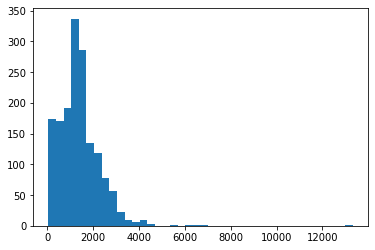

In [65]:
areas = []

for cnt in contours:
    areas = np.append(areas, cv2.contourArea(cnt))

plt.hist(areas, bins=40)

Se muestra que casi todas las palabras tienen la misma área. Se podrían eliminar primero los _outliers_ más extremos, nótese que como la distribución no es normal no se puede utilizar un método parámetrico.

Adicionalmente, podríamos usar la información del área para aproximar cuantas letras tiene cada palabra.

### Actividades pendientes de programación.

1. Probar con distintas retículas en la dilatación.
2. Probar erosión para quitar manchas pequeñas.
3. Utilizar el histograma para quitar las figuras más grandes y más pequeñas.
4. Guardar cada palabra en una imagen separada. (Hacerlo con algunas).
5. Pensar en una manera que la estadística del tamaño de las palabras podrías ser útil. Por ejemplo, aquí un sistema, de forma automática ya puede saber que un texto tiene dos columnas.

### Actividades pendientes del ensayo.
1. Justificar en el contexto de la inteligencia artificial, porque es útil separ palabras.
2. Justificar también porque es útil hacer estadística con la posición y tamaño de las palabras.
3. Escritura del documento.
4. Conclusión
5. Formato del documento.




